# **Part 1 - Conv2D**

## **Introduction**

In this section, we delve into the development of a custom layer for PyTorch tensors that combines two essential operations: padding and cross-correlation. While PyTorch offers built-in functions for convolutional operations like torch.nn.Conv2d, we explore a more granular approach, allowing for a deeper understanding of these fundamental operations. Our objective is to provide a comprehensive understanding of each component and its role within the broader context of neural network architecture. Through detailed explanations and documented code, we aim to empower practitioners to craft custom layers tailored to specific requirements, thereby enhancing flexibility and promoting deeper comprehension of convolutional neural networks. Let's embark on this exploration into the heart of convolutional neural networks, unraveling the intricacies of convolution in PyTorch.

In [ ]:
import torch
import torch.nn as nn

## **Convolution**

Our custom layer initiates by zero-padding the input tensor. This process, handled by the zero_pad function, extends the input with zeros along its spatial dimensions. Zero-padding maintains spatial consistency crucial for subsequent operations like cross-correlation, ensuring effective feature extraction across the input space. By integrating zero-padding, our layer aligns with CNN principles, facilitating robust feature learning and preserving spatial information essential for accurate inference. Thus, zero_pad plays a pivotal role in preparing the input for subsequent operations, enhancing the overall functionality of our neural network model.

In [ ]:
def zero_pad(input_tensor, pad=0):
    """
    Apply zero-padding to the input tensor.

    Args:
        input_tensor (torch.Tensor): The input tensor to be padded.
        pad (int): The number of zero-padding rows and columns to be added to each side of the input tensor.
                   Default is 0.

    Returns:
        torch.Tensor: The padded tensor.
    """

    # Pad the two last dimensions with pad zeros in each dimension
    size_in = input_tensor.size()
    h_in, w_in = size_in[-2:]
    size_out = h_in + 2 * pad, w_in + 2 * pad  # Calculate the size of the output tensor after padding
    tensor_out = torch.zeros(*size_in[:-2], *size_out) # Initialize output tensor
    tensor_out[..., pad:h_in + pad, pad:w_in + pad] = input_tensor.clone()  # Copy the values of the original tensor into the padded tensor
    return tensor_out



In [ ]:
tensor_ex = torch.arange(1,41).reshape(2,4,5)
zero_pad(tensor_ex,2)

tensor([[[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  1.,  2.,  3.,  4.,  5.,  0.,  0.],
         [ 0.,  0.,  6.,  7.,  8.,  9., 10.,  0.,  0.],
         [ 0.,  0., 11., 12., 13., 14., 15.,  0.,  0.],
         [ 0.,  0., 16., 17., 18., 19., 20.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]],

        [[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0., 21., 22., 23., 24., 25.,  0.,  0.],
         [ 0.,  0., 26., 27., 28., 29., 30.,  0.,  0.],
         [ 0.,  0., 31., 32., 33., 34., 35.,  0.,  0.],
         [ 0.,  0., 36., 37., 38., 39., 40.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]]])

The subsequent step in our layer involves convolution, a pivotal operation in neural network architectures. Convolutional operations are traditionally computed through direct spatial operations, but to optimize efficiency, we harness the power of the Fourier Transform. By exploiting the properties of this transform, such as the convolution theorem, we perform convolution in the frequency domain. This involves multiplying the Fourier transforms of the input tensor and the kernel, and subsequently computing the inverse Fourier transform to obtain the result of the cross-correlation. Leveraging Fourier transforms not only enhances computational efficiency but also provides insights into the frequency-domain representation of convolutional operations, enriching our understanding of signal processing in neural networks.

In [ ]:
def cross_correlate4d(input_tensor, kernel, stride=1):
    """
    Perform 2-dimensional cross-correlation between a 4-dimensional input tensor and 4-dimensional kernel tensor.

    Args:
      input_tensor (torch.Tensor): The input tensor with shape [batch_size, in_channels, height, width].
      kernel (torch.Tensor): The kernel tensor with shape [out_channels, in_channels, kernel_height, kernel_width].
      stride (int): The stride of the cross-correlation operation. Default is 1.

    Returns:
      torch.Tensor: The result tensor after cross-correlation with shape [batch_size, out_channels, out_height, out_width].
    """

    # Get  sizes
    input_height, input_width = input_tensor.size()[-2:]
    kernel_height, kernel_width = kernel.size()[-2:]
    batch_size = input_tensor.shape[0]
    n_channels_out = kernel.shape[0]

    # Compute the size of the result tensor
    out_height = (input_height - kernel_height) // stride + 1
    out_width = (input_width - kernel_width) // stride + 1
    result_shape = batch_size, n_channels_out, out_height, out_width

    # Initialize result tensor
    result = torch.zeros(*result_shape, dtype=input_tensor.dtype)

    for i in range(0, input_height - kernel_height + 1, stride):
        for j in range(0, input_width - kernel_width + 1, stride):
            input_patch = input_tensor[:, :, i:i + kernel_height, j:j + kernel_width]
            padded_input_patch = input_patch.unsqueeze(1) # New dimensions - [N,1,Cin,Oh,Ow]
            result[:, :, i // stride, j // stride] = torch.sum(padded_input_patch * kernel, dim=(2, 3, 4))


    return result

In [ ]:
tensor_ex = torch.arange(1,151,dtype=torch.float32).reshape(3,2,5,5)
kernel_ex = torch.ones(8,dtype=torch.float32).reshape(1,2,2,2)
print("Example tensor: ", tensor_ex, sep = '\n')
print("Example kernel: ",kernel_ex,sep = '\n')
print("Convoultion result: ",cross_correlate4d(tensor_ex, kernel_ex, stride=2), sep = '\n')

Example tensor: 
tensor([[[[  1.,   2.,   3.,   4.,   5.],
          [  6.,   7.,   8.,   9.,  10.],
          [ 11.,  12.,  13.,  14.,  15.],
          [ 16.,  17.,  18.,  19.,  20.],
          [ 21.,  22.,  23.,  24.,  25.]],

         [[ 26.,  27.,  28.,  29.,  30.],
          [ 31.,  32.,  33.,  34.,  35.],
          [ 36.,  37.,  38.,  39.,  40.],
          [ 41.,  42.,  43.,  44.,  45.],
          [ 46.,  47.,  48.,  49.,  50.]]],


        [[[ 51.,  52.,  53.,  54.,  55.],
          [ 56.,  57.,  58.,  59.,  60.],
          [ 61.,  62.,  63.,  64.,  65.],
          [ 66.,  67.,  68.,  69.,  70.],
          [ 71.,  72.,  73.,  74.,  75.]],

         [[ 76.,  77.,  78.,  79.,  80.],
          [ 81.,  82.,  83.,  84.,  85.],
          [ 86.,  87.,  88.,  89.,  90.],
          [ 91.,  92.,  93.,  94.,  95.],
          [ 96.,  97.,  98.,  99., 100.]]],


        [[[101., 102., 103., 104., 105.],
          [106., 107., 108., 109., 110.],
          [111., 112., 113., 114., 115.],
     

## **The New Layer**

To ensure the successful execution of the convolution operation, additional preparatory steps may be necessary. Primarily, it's crucial to validate the input tensor. Each tensor is expected to adhere to a specific dimensionality: either 3D (unbatched) or 4D (batched). This validation step ensures that the input is compatible with the convolution operation, laying the groundwork for seamless execution

In [ ]:
def is_valid_num_dimensions(tensor):
    """
    Check if the input tensor has a valid number of dimensions (3 or 4) for convolution operations.

    Args:
      tensor (torch.Tensor): The input tensor.

    Returns:
      bool: True if the number of dimensions is 3 (unbatched) or 4 (batched), otherwise False.
    """

    # return true if num dimenssion is not 3(unbatched) or 4(batched)
    num_d_input = tensor.dim()
    if num_d_input!=3 and num_d_input!=4:
        return False
    return True


For consistency and ease of processing, we choose to work exclusively with 4D tensors throughout our operations. To facilitate this standardization, we introduce the pad_tensor_dimensions function. This function serves the purpose of transforming input tensors into a uniform 4D format.

In [ ]:
def pad_tensor_dimensions(input_tensor, desired_num_d=4):
    """
    Pad a tensor's dimensions at the beginning until the desired number of dimensions is reached.

    Args:
      input_tensor (torch.Tensor): The input tensor.
      desired_num_d (int): The desired number of dimensions for the output tensor. Default is 4.

    Returns:
      torch.Tensor: The output tensor with the desired number of dimensions.

    """
    # att tensor singeltopn dimensions at start until desired num dimensions is reached
    tensor_num_d = input_tensor.dim()
    out_tensor = input_tensor.clone()
    for i in range(desired_num_d - tensor_num_d):
        out_tensor.unsqueeze(0)
    return out_tensor

Later in our workflow, we'll need to initialize the kernel of the layer with random numbers uniformly distributed within a specified range. To streamline this process, we introduce the generate_uniform_numbers_in_range function. This function is designed to efficiently generate random numbers adhering to a uniform distribution within the specified range. By leveraging this function, we ensure consistent and controlled initialization of kernel weights, a critical step in the training and optimization of our neural network model.

In [ ]:
def generate_uniform_numbers_in_range(k, size):
    """
    Generates uniform random numbers in the range [-k, k].

    Args:
        k (float): Scaling factor for the range.
        size (int or tuple of ints): Size of the tensor to be generated.

    Returns:
        torch.Tensor: Tensor of uniform random numbers in the range [-k, k].

    """
    uniform_numbers = torch.rand(size)
    scaled_numbers = 2 * k * (uniform_numbers - 0.5)
    return scaled_numbers

The Conv2D layer encapsulates a customizable 2D convolutional operation tailored for neural network architectures. With parameters for input and output channels, kernel size, stride, and padding, it offers flexibility in modeling spatial hierarchies within data. Leveraging a trainable kernel initialized uniformly, this layer efficiently performs convolution operations, essential for feature extraction and representation learning in convolutional neural networks.

In [ ]:
class Conv2D(nn.Module):

    def __init__(self,in_channels=1,out_channels=1, kernel_size=(1,1), stride=1, padding=0):
        """
        Custom 2-dimensional convolutional layer.

        Args:
            in_channels (int): Number of input channels. Default is 1.
            out_channels (int): Number of output channels. Default is 1.
            kernel_size (tuple): Spatial Size of the convolutional kernel. Default is (1, 1).
            stride (int): Stride of the convolution operation. Default is 1.
            padding (int): Amount of zero-padding added to the input tensor. Default is 0.

        Attributes:
            out_channels (int): Number of output channels.
            in_channels (int): Number of input channels.
            kernel_size (tuple): Size of the convolutional kernel.
            stride (int): Stride of the convolution operation.
            padding (int): Amount of zero-padding added to the input tensor.
            kernel (nn.Parameter): kernel (torch.nn.Parameter): Trainable parameter
              representing the convolutional kernel initialized uniformly in the
              range -k^-0.5 and k^-0.5, where k is the size of the kernel.

        """
        super(Conv2D, self).__init__()
        self.out_channels = out_channels
        self.in_channels = in_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        self.bias = nn.Parameter(torch.randn(out_channels))
        self.init_bias()

        self.kernel = nn.Parameter(torch.ones(out_channels,in_channels, *kernel_size))  # maybe initialize with different values
        self.init_kernel()



    def init_kernel(self):
        """
        Initialize the convolutional kernel with values sampled from a uniform
        distribution between -k^-0.5 and k^-0.5, where k is the size of the kernel.

        """
        numel_kernel = self.kernel.numel()
        params = generate_uniform_numbers_in_range(numel_kernel ** -0.5, numel_kernel)
        params = params.reshape(self.out_channels, self.in_channels, *self.kernel_size)
        self.kernel = nn.Parameter(params)

    def init_bias(self):
        """
        Initialize the layer's bias with values sampled from a uniform
        distribution between -k^-0.5 and k^-0.5, where k is Cin*Kh*Kw

        """
        numel_bias = self.out_channels
        k = (self.in_channels * self.kernel_size[0] * self.kernel_size[1]) ** -0.5
        params = generate_uniform_numbers_in_range(k, numel_bias)
        self.kernel = nn.Parameter(params)

    def forward(self, input_tensor):
        """
        Perform forward pass of the convolutional layer.

        Args:
            input_tensor (torch.Tensor): Input tensor to be convolved.

        Returns:
            torch.Tensor: Output tensor after convolution.

        Raises:
            ValueError: If the input tensor has an invalid number of dimensions or an unexpected number of channels.

        """

        # Input tensor validation
        if not is_valid_num_dimensions(input_tensor):
            raise ValueError(f"Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size {input_tensor.shape}")

        # Ensure input tensor is 4D
        tensor = pad_tensor_dimensions(input_tensor, 4)

        # Check input tensor's number of channels
        tensor_in_channels = tensor.shape[1]
        if self.in_channels!=tensor_in_channels: # got unexpected number of channels
            raise ValueError(f"expected input to have {self.in_channels} channels,  but got {tensor_in_channels} channels instead")

        # Check if input dimensions are sufficient for convolution with the kernel
        input_height, input_width = input_tensor.size()[-2:]

        if input_height < self.kernel_size[0] or input_width < self.kernel_size[1]:
            raise ValueError(f"Input dimensions are too small for the kernel. "
                             f"Input dimensions: ({input_height}, {input_width}), "
                             f"Kernel size: ({self.kernel_size}, {self.kernel_size})")

        # Pad the input tensor
        tensor_padded =  zero_pad(input_tensor, pad=self.padding)

        # Perform cross-correlation
        result = cross_correlate4d(tensor_padded, self.kernel, stride=self.stride)

        # Add bias (broadcasting to match output shape)
        result += self.bias.view(1, -1, 1, 1)

        # Squeeze back the result tensor if input_tensor is 3D
        if input_tensor.dim() == 3:
            result = result.squeeze(0)

        return result


In [ ]:
N = 1
Cin = 1
Co = 3
h = 8
w = 5
Kh = 3
Kw = 2
numel = N * Cin * h * w
stri = 2
padd = 2

# order of parameter(kernel) shape - out_channels, in_channels, *kernels_size =
myLayer = Conv2D(in_channels=Cin, out_channels=Co, kernel_size=(Kh, Kw), stride=stri, padding=padd)

# Create torch convolution layer for comparison
layer = nn.Conv2d(in_channels=Cin, out_channels=Co, kernel_size=(Kh, Kw), stride=stri, padding=padd, bias=True)

# Replace the layers' kernel
myLayer.kernel  = layer.weight
myLayer.bias  = layer.bias

# Create an example tensor
tensor_ex = torch.arange(1, numel + 1, dtype=torch.float32).reshape(N, Cin, h, w)



In [ ]:
print("Convolution using nn.Conv2D:", layer.forward(tensor_ex),sep = '\n')

Convolution using nn.Conv2D:
tensor([[[[  0.2926,   0.4661,   0.7485,   0.8376],
          [  0.2926,   0.3231,  -0.3007,  -2.2994],
          [  0.2926,  -2.7958,  -3.4195,  -5.7722],
          [  0.2926,  -5.9146,  -6.5384,  -9.2450],
          [  0.2926, -14.8554, -15.7616, -17.6227]],

         [[  0.1566,   1.0557,   2.3328,   2.0466],
          [  0.1566,  11.6619,  15.2972,   9.0472],
          [  0.1566,  29.8387,  33.4741,  18.0831],
          [  0.1566,  48.0156,  51.6510,  27.1189],
          [  0.1566,  39.7520,  42.1103,  19.1449]],

         [[  0.3419,   0.3900,   0.7699,   2.0011],
          [  0.3419,   5.7363,   6.8898,   9.7479],
          [  0.3419,  11.5037,  12.6572,  18.0390],
          [  0.3419,  17.2712,  18.4247,  26.3301],
          [  0.3419,  15.3919,  16.1655,  19.6882]]]],
       grad_fn=<ConvolutionBackward0>)


In [ ]:
print("Convolution using Conv2D:", myLayer.forward(tensor_ex),sep = '\n')

Convolution using Conv2D:
tensor([[[[  0.2926,   0.4661,   0.7485,   0.8376],
          [  0.2926,   0.3231,  -0.3007,  -2.2994],
          [  0.2926,  -2.7958,  -3.4195,  -5.7722],
          [  0.2926,  -5.9146,  -6.5384,  -9.2450],
          [  0.2926, -14.8554, -15.7616, -17.6227]],

         [[  0.1566,   1.0557,   2.3328,   2.0466],
          [  0.1566,  11.6619,  15.2972,   9.0472],
          [  0.1566,  29.8387,  33.4741,  18.0831],
          [  0.1566,  48.0156,  51.6510,  27.1189],
          [  0.1566,  39.7520,  42.1103,  19.1449]],

         [[  0.3419,   0.3900,   0.7699,   2.0011],
          [  0.3419,   5.7363,   6.8898,   9.7479],
          [  0.3419,  11.5037,  12.6572,  18.0390],
          [  0.3419,  17.2712,  18.4247,  26.3301],
          [  0.3419,  15.3919,  16.1655,  19.6882]]]], grad_fn=<AddBackward0>)


In [ ]:
print(torch.all(abs(layer.forward(tensor_ex) - myLayer.forward(tensor_ex))<0.01))

tensor(True)


# **Part 2 - Analytical analysis**

Given a one channel image $X \in \mathbb{R}^{3 \times 3}$ and a kernel $K \in \mathbb{R}^{2 \times 1}$, we would like to calculate the gradient of the cost function on the output of the convolution operation between the image and the kernel, i.e., $Y = X * K \in \mathbb{R}^{2 \times 3}$.

We will denote the cost function as $C(Y)$ and we will assume that the partial derivative of $C$ with respect to $Y$ is given as $\frac{\partial C}{\partial Y_{ij}}$ for $i \in \{0,1\},\; j \in \{0,1,2\}$.


$$
\frac{\partial Y_{ij}}{\partial K_{l}} = X_{i+l,j} \quad \text{for} \quad l \in \{0,1\}
$$

$$
\frac{\partial Y_{ij}}{\partial X_{mn}}=
\begin{cases}
0 & \text{if } n \neq j \text{ or } (m-i) \notin \{0,1\} \\
K_{m-i} & \text{otherwise}
\end{cases}
$$

where
$$
K =
\begin{pmatrix}
K_1 \\
K_2
\end{pmatrix}
$$

Therefore:
$$
\frac{\partial C}{\partial K_{l}} = \sum_{j=0}^{2} \sum_{i=0}^{1} \frac{\partial C}{\partial Y_{ij}} \cdot \frac{\partial Y_{ij}}{\partial K_l} = \sum_{j=0}^{2} \sum_{i=0}^{1} \frac{\partial C}{\partial Y_{ij}} \cdot X_{i+l,j}
$$

$$
\frac{\partial C}{\partial X_{mn}} = \sum_{j=0}^{2} \sum_{i=0}^{1} \frac{\partial C}{\partial Y_{ij}} \cdot \frac{\partial Y_{ij}}{\partial X_{mn}} = \sum_{i=0}^{1} \frac{\partial C}{\partial Y_{in}} \cdot \frac{\partial Y_{in}}{\partial X_{mn}} =
\begin{cases}
\frac{\partial C}{\partial Y_{0n}} \cdot K_0 & \text{if } m=0 \\
\frac{\partial C}{\partial Y_{1n}} \cdot K_0 + \frac{\partial C}{\partial Y_{0n}} \cdot K_1 & \text{if } m=1 \\
\frac{\partial C}{\partial Y_{1n}} \cdot K_1 & \text{if } m=2
\end{cases}
$$


# **Part 3 - CIFAR-10 Transfer Learning**

In [ ]:
import torchvision
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from torchvision import models
import torchvision.transforms as transforms
import torch.optim as optim
import psutil
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

## **Introduction**

In this secion, we will explore the application of transfer learning using ResNet models for image classification on the CIFAR-10 dataset. Transfer learning leverages pre-trained models, such as ResNet, that were originally trained on large-scale datasets like ImageNet. By fine-tuning these pre-trained models on smaller datasets like CIFAR-10, we can harness the knowledge learned from the original task and adapt it to our specific classification problem.

**About ResNet**

ResNet (Residual Network) is a deep convolutional neural network architecture introduced by Microsoft Research in 2015. ResNet is known for its groundbreaking design, which includes skip connections or shortcuts that enable training of very deep neural networks (up to hundreds of layers) without suffering from the vanishing gradient problem.

The ResNet model comprises several residual blocks, each consisting of convolutional layers, batch normalization, and ReLU activation functions. These residual blocks facilitate the learning of residual mappings, allowing the model to effectively capture intricate features in the input images. The ResNet architecture has achieved state-of-the-art performance on various image classification tasks and has become a popular choice for transfer learning due to its scalability and effectiveness.

## **CIFAR-10 Dataset and Adaptation**

The CIFAR-10 dataset serves as a standard benchmark for image classification tasks, comprising 60,000 32x32 color images distributed across 10 classes. Each class contains 6,000 images, evenly split between the training and test sets. Given the small size and low resolution of CIFAR-10 compared to datasets like ImageNet, adapting a pre-trained ResNet model for CIFAR-10 classification requires careful adjustments. One critical adaptation involves resizing the CIFAR-10 images to match the input size expected by the ResNet model, typically 224x224 pixels, ensuring compatibility between the dataset and the model architecture. Additionally, the data is normalized to match the mean and standard deviation of the ImageNet dataset, on which the ResNet model was originally trained. This normalization step ensures that the input data distribution aligns with the assumptions made during the pre-training of the ResNet model, facilitating effective transfer learning. Modifications are also made to the classification head of the ResNet model to accommodate the 10 output classes in CIFAR-10. Together, these adaptations enable us to leverage the knowledge learned by the ResNet model on ImageNet for accurate classification of CIFAR-10 images.

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to match ResNet input size
    transforms.ToTensor(),           # Convert images to tensors
    transforms.Normalize(           # Normalize based on ImageNet mean and std
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [ ]:
# Used GPT here
# Load CIFAR-10 dataset and perform transformation as defined above
full_dataset = torchvision.datasets.CIFAR10(root='./data1', train=True, download=True, transform=transform)

# Split dataset
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
# Define data loaders
trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load test set with the same transformations as used for training
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=32, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


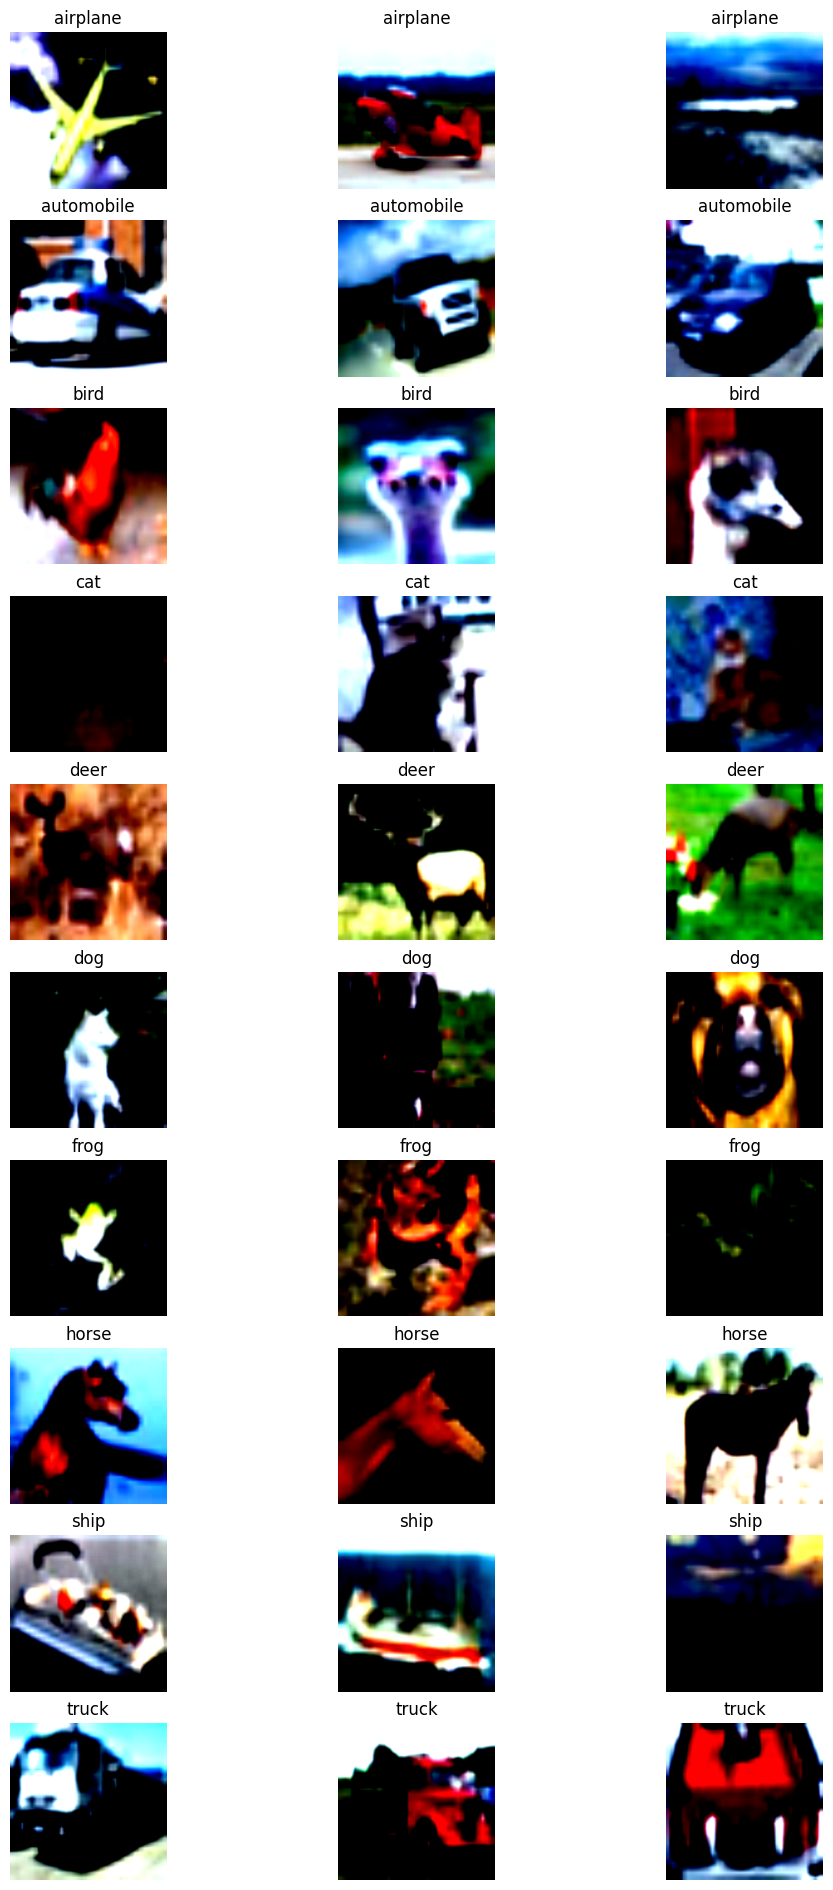

In [ ]:
# Used GPT here
# Get classes
classes = full_dataset.classes

# Create a dictionary to store examples for each class
examples_per_class = {class_name: [] for class_name in classes}

n_per_class = 3
num_classes = len(classes)
cnt = 0 # Keep track of how much images already stored
# Store examples from each class
for i in range(len(train_dataset)):
    if cnt == num_classes * n_per_class: # Found enought images
        break
    image, label = train_dataset[i]
    class_name = classes[label]
    if len(examples_per_class[class_name]) < n_per_class: # If not enought images from this class has been shown yet
        cnt +=1
        examples_per_class[class_name].append(image)


# Display examples
plt.figure(figsize=(12, 24))
for i, (class_name, examples) in enumerate(examples_per_class.items()):
    for j, example in enumerate(examples):
        plt.subplot(10, 3, i * 3 + j + 1)
        plt.imshow(example.permute(1, 2, 0))  # Transpose the image data to (height, width, channels)
        plt.title(class_name)
        plt.axis('off')
plt.show()



## **Preparing the ResNet18 Model**

To begin our classification task on the CIFAR-10 dataset, we leveraged a pre-trained ResNet18 model, a popular variant of the ResNet architecture known for its effectiveness and efficiency. Upon loading the pre-trained ResNet18 model using PyTorch's torchvision library, we made several modifications to adapt it to our specific classification problem. Firstly, we replaced the original classifier head of the ResNet18 model, which was designed for ImageNet's 1,000 classes, with a new classifier head tailored to the CIFAR-10 dataset's 10 classes. This involved adjusting the number of output neurons in the final fully connected layer to match the number of classes in CIFAR-10. Additionally, to ensure that the pre-trained weights of the ResNet18 backbone layers remain intact and retain their learned features, we froze all parameters of the model except those in the classifier head. By making the backbone layers untrainable, we enable the model to focus solely on learning the optimal parameters for the new classification task, thereby accelerating convergence and potentially improving performance.

In [ ]:
resnet_model = models.resnet18(pretrained=True)
for param in resnet_model.parameters():
    param.requires_grad = False


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Replace the classification head to match the cifar-10 dataset 10 classes, and make it trainable

In [ ]:
resnet_model.fc = nn.modules.linear.Linear(in_features=512, out_features=10, bias=True)
resnet_model.fc.requires_grad = True


In [ ]:
for layer in resnet_model.children():
    print(layer)

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fal

In [ ]:
# Set Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet_model.to(device);

## **Training the Model**

With the pre-trained ResNet18 model prepared and modified for CIFAR-10 classification, we proceeded to train the model on the training dataset. The training process involved iterating over multiple epochs, with each epoch consisting of mini-batch iterations over the training data. During each iteration, the model's parameters were updated using gradient descent optimization with stochastic gradient descent (SGD) as the optimizer. The optimization objective was to minimize the classification loss, which was computed using the cross-entropy loss function. This loss function is well-suited for multi-class classification tasks, penalizing the model based on the difference between predicted probabilities and true class labels. To monitor the model's performance and prevent overfitting, we evaluated the model on a separate validation set after each epoch. The model's accuracy on the validation set was used as a metric to determine the best-performing model. We adopted a strategy to store the model with the highest accuracy on the validation set, ensuring that we retained the optimal model parameters throughout the training process. By selecting the model with the best validation accuracy, we aimed to generalize well to unseen data and achieve robust performance on the test set.

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.fc.parameters(), lr=0.0001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

We will use the evaluate function to evaluate the model on the validation data, and later on the test data

In [ ]:
# Used GPT here
def evaluate(model, device, dataloader, get_misclassified_confidence=False):
    model.eval()
    misclassified_with_confidence = []

    correct = 0
    total = 0

    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if get_misclassified_confidence:
              # Calculate confidence scores
                softmax_probs = nn.functional.softmax(outputs, dim=1)
                confidence_scores = torch.max(softmax_probs, dim=1)[0]

              # Find misclassified images with highest confidence
                misclassified_mask = predicted != labels
                misclassified_with_confidence.extend([(image, pred.item(), true.item(), confidence.item())
                                                            for image, pred, true, confidence in zip(
                                                                images[misclassified_mask],
                                                                predicted[misclassified_mask],
                                                                labels[misclassified_mask],
                                                                confidence_scores[misclassified_mask])])

    accuracy = 100 * correct / total
    if get_misclassified_confidence:
        return accuracy, misclassified_with_confidence
    return accuracy

Let's train the model and store the parameters that yields the best accuracy on the validation set

In [ ]:
# Used GPT here
def train(num_epochs, model, device, optimizer,scheduler, criterion, train_loader, val_loader):

    best_val_accuracy = 0.0
    best_model_state = None

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        correct_train = 0
        total_train = 0
        running_loss = 0.0

        for i, data in enumerate(train_loader, 0):

            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = 100 * correct_train / total_train  # Training accuracy for the current epoch
        print(
            f"Epoch {epoch + 1}, Training Loss: {running_loss / len(train_loader)}, Training Accuracy: {train_accuracy}%")

        running_loss = 0.0

        # Evaluate the model on the validation set
        val_accuracy = evaluate(model, device, val_loader, get_misclassified_confidence = False)
        print('Epoch %d: Validation Accuracy: %.2f %%' % (epoch + 1, val_accuracy))

        # Check if current validation accuracy is better than the best seen so far
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model_state = model.state_dict()

        scheduler.step(val_accuracy)

    # Load the best model state
    model.load_state_dict(best_model_state)

    print('Finished Training')


In [ ]:
train(num_epochs=6, model=resnet_model, device=device, optimizer=optimizer, scheduler=scheduler, criterion=criterion, train_loader=trainloader, val_loader=valloader)

Epoch 1, Training Loss: 1.4427169787406922, Training Accuracy: 58.0175%
Epoch 1: Validation Accuracy: 72.91 %
Epoch 2, Training Loss: 0.8580887035369873, Training Accuracy: 74.97%
Epoch 2: Validation Accuracy: 76.33 %
Epoch 3, Training Loss: 0.7272735946178436, Training Accuracy: 77.2625%
Epoch 3: Validation Accuracy: 77.47 %
Epoch 4, Training Loss: 0.6685443279027938, Training Accuracy: 78.4275%
Epoch 4: Validation Accuracy: 78.23 %
Epoch 5, Training Loss: 0.6421091767787933, Training Accuracy: 79.135%
Epoch 5: Validation Accuracy: 78.52 %
Epoch 6, Training Loss: 0.6385388261556625, Training Accuracy: 79.225%
Epoch 6: Validation Accuracy: 78.62 %
Finished Training


We will procceed by evaluating the model on the test set

In [ ]:
def test(model, device, test_loader):
    # Evaluate the model on the test set
    accuracy, misclassified_with_confidence = evaluate(model, device, test_loader, get_misclassified_confidence=True)
    print(f"Accuracy on test set is: {accuracy} %")
    return misclassified_with_confidence


In [ ]:
misclassified_with_highest_confidence =  test(resnet_model, device=device, test_loader=testloader)



Accuracy on test set is: 78.56 %


Image 1: Predicted class ship, True class airplane, Confidence 0.996


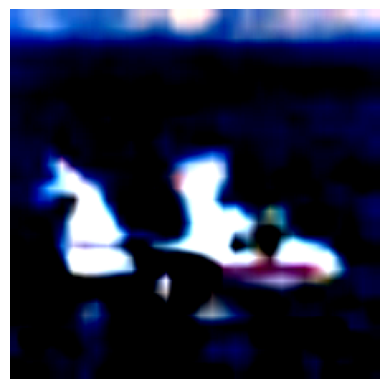

Image 2: Predicted class deer, True class bird, Confidence 0.984


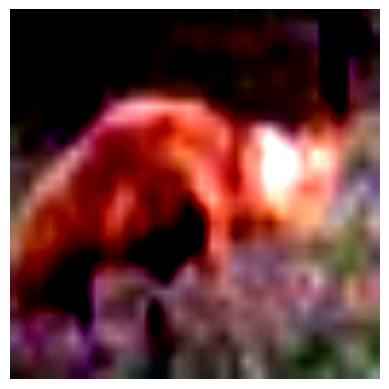

Image 3: Predicted class frog, True class cat, Confidence 0.983


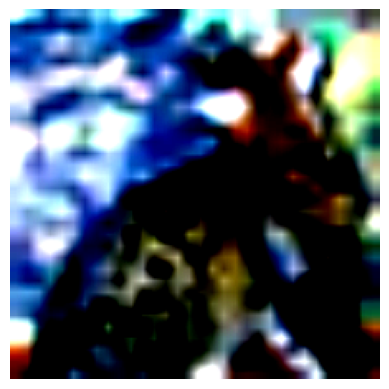

Image 4: Predicted class ship, True class airplane, Confidence 0.981


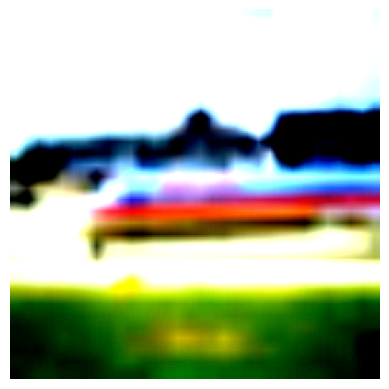

Image 5: Predicted class frog, True class deer, Confidence 0.974


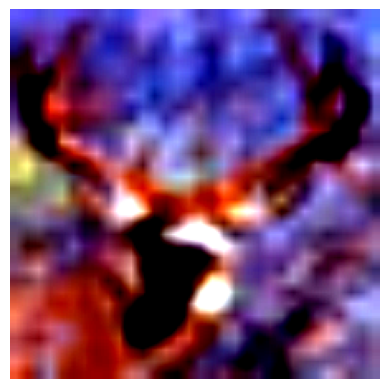

Image 6: Predicted class bird, True class frog, Confidence 0.968


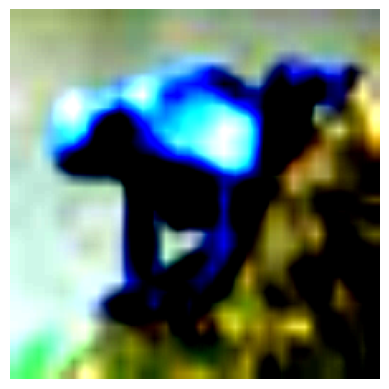

Image 7: Predicted class automobile, True class truck, Confidence 0.968


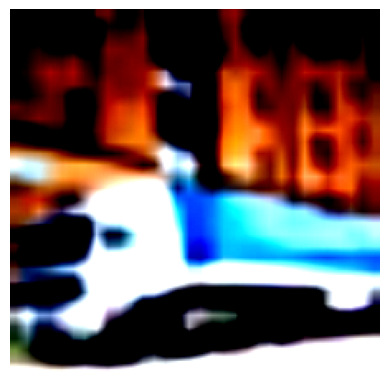

Image 8: Predicted class automobile, True class truck, Confidence 0.968


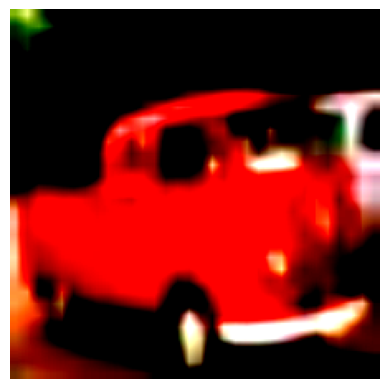

Image 9: Predicted class automobile, True class truck, Confidence 0.967


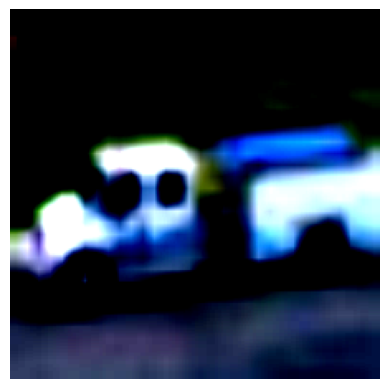

Image 10: Predicted class dog, True class horse, Confidence 0.964


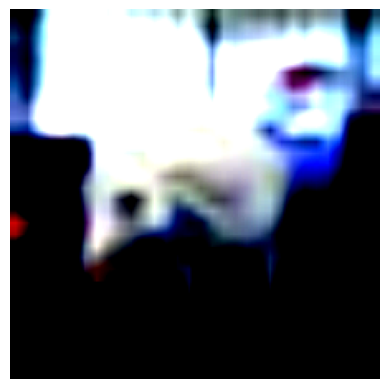

In [ ]:
# Used GPT here
# Sort misclassified images by confidence in descending order
misclassified_with_highest_confidence.sort(key=lambda x: x[3], reverse=True);

# Display the top 10 misclassified images with highest confidence
num_images_to_display = 10
for i in range(num_images_to_display):
    image, predicted_class, true_class, confidence = misclassified_with_highest_confidence[i]
    print(f"Image {i+1}: Predicted class {classes[predicted_class]}, True class {classes[true_class]}, Confidence {confidence:.3f}")
    plt.imshow(image.permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.show()

## **New Resnet Model**

n this section, we define a custom ResNet model tailored specifically for the CIFAR-10 dataset. The custom ResNet architecture is designed to accommodate the smaller and lower-resolution images in CIFAR-10 while retaining the effectiveness of the original ResNet design. The model begins with an initial convolutional layer, followed by batch normalization and ReLU activation, to extract features from the input images. Next, a series of residual blocks are employed to capture hierarchical features within the images. Each residual block consists of convolutional layers with batch normalization and ReLU activation, facilitating feature learning and adaptation to the CIFAR-10 dataset. After the residual blocks, an adaptive average pooling layer is applied to aggregate spatial information and ensure compatibility with images of arbitrary size. Finally, a classification head consisting of a fully connected layer is appended to the model to predict the probabilities for each class in CIFAR-10.

In [ ]:
class ResidualBlock(nn.Module): # works well
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # shortcut connection
        if stride != 1 or in_channels != out_channels: # in case the dimensions of the original tensor and the current result aren't matching
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()  # in case the dimensions are matching

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(residual)
        out = self.relu(out)
        return out



class MyResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(MyResNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.block1 = ResidualBlock(32, 64, stride=1)
        self.block2 = ResidualBlock(64, 128, stride=2)
        self.block3 = ResidualBlock(128, 256, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)


    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x





In [ ]:
# Instantiate the custom model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
my_model = MyResNet()
my_model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(my_model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

Let's train and test the new model

In [ ]:
train(num_epochs=20, model=my_model, device=device, optimizer=optimizer, scheduler=scheduler, criterion=criterion, train_loader=trainloader, val_loader=valloader)


Epoch 1, Training Loss: 1.6921511931419373, Training Accuracy: 37.8025%
Epoch 1: Validation Accuracy: 47.10 %
Epoch 2, Training Loss: 1.489341384458542, Training Accuracy: 46.035%
Epoch 2: Validation Accuracy: 48.82 %
Epoch 3, Training Loss: 1.3056485650539398, Training Accuracy: 53.01%
Epoch 3: Validation Accuracy: 57.82 %
Epoch 4, Training Loss: 1.1911251830577851, Training Accuracy: 57.24%
Epoch 4: Validation Accuracy: 57.09 %
Epoch 5, Training Loss: 1.0936816595077514, Training Accuracy: 61.105%
Epoch 5: Validation Accuracy: 60.14 %
Epoch 6, Training Loss: 1.0089870792865754, Training Accuracy: 64.065%
Epoch 6: Validation Accuracy: 65.69 %
Epoch 7, Training Loss: 0.9358135365724564, Training Accuracy: 66.985%
Epoch 7: Validation Accuracy: 68.89 %
Epoch 8, Training Loss: 0.7555162368535996, Training Accuracy: 73.355%
Epoch 8: Validation Accuracy: 72.18 %
Epoch 9, Training Loss: 0.7210503870248794, Training Accuracy: 74.7125%
Epoch 9: Validation Accuracy: 72.99 %
Epoch 10, Training L

In [ ]:
_ = test(model=my_model, device=device, test_loader=testloader)

Accuracy on test set is: 74.1 %


# **Comparison**

Each model has its own advantages, and choosing the right one depends on the specific task. Let's review the advantages of each model:

**ResNet18:**
1. Higher accuracy on the test set.
2. Much faster training time.
3. Known for its effectiveness in transfer learning due to the large dataset it was originally trained on and its robust architecture.

**My custum Resnet:**
1. Allows more flexibility and control over the architecture, which can lead to better results in some cases.
2. Each parameter learned is specifically suited to the task, potentially yielding better results for certain applications.

Given the higher accuracy and faster training time, I would choose transfer learning with ResNet18 for this task.